In [1]:
import matplotlib.pyplot as plt
import numpy as np

from protstruc import AntibodyStructureBatch
from protstruc.general import ATOM

In [2]:
asb = AntibodyStructureBatch.from_pdb('4uuj.pdb', heavy_chain_id='A', light_chain_id='B', antigen_chain_ids=[['C']])

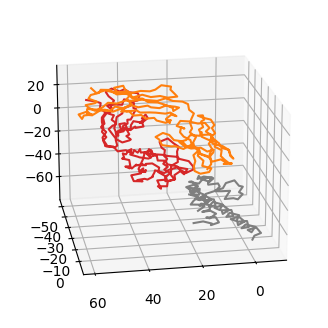

In [3]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

xyz = asb.get_xyz()[0]
chain_idx = asb.get_chain_idx()[0]
chain_ids = asb.get_chain_ids()[0]

for idx in np.unique(chain_idx):
    mask = chain_idx == idx

    chain_id = chain_ids[idx]
    if chain_id == 'A':
        c = 'C3'  # color heavy chain with red
    elif chain_id == 'B':
        c = 'C1'  # color light chain with orange
    else:
        c = 'C7'  # color antigen with grey

    _xyz = xyz[mask, ATOM.CA]  # chain-specific CA coordinates
    ax.plot(_xyz[:, 0], _xyz[:, 1], _xyz[:, 2], c=c)

ax.view_init(20, 80)

Let's make a new `AntibodyStructureBatch` object by only taking the nearest 128 residues surrounding the CDR anchors. 

First, we need to get a mask for CDR anchors.

In [4]:
anchor_mask = asb.get_cdr_anchor_mask()[0]
anchor_mask.shape

torch.Size([545])

As expected, we can see that there are 12 CDR anchors in total (6 in heavy chain, and 6 in light chain).

In [5]:
anchor_mask.sum()

tensor(12)

Get 3D coordinates of alpha carbons of CDR anchor residues.

In [6]:
anchor_xyz = asb.get_xyz()[0][anchor_mask, ATOM.CA]
anchor_xyz.shape

torch.Size([12, 3])

Then we can compute the k-nearest neighboring residues for all of the CDR anchor residues.
Note that for each residue in the protein (or protein complex), the distance is computed as the minimum distance to any of the anchor residues.

In [7]:
k_nearest_mask = asb.get_topk_nearest_residue_mask(query_xyz=anchor_xyz, k=128)[0]
k_nearest_mask.shape

torch.Size([545])

Verify that `k_nearest_mask` represents 128 residues.

In [8]:
k_nearest_mask.sum()

tensor(128)

Now let's visualize the positions of the nearest 128 residues.

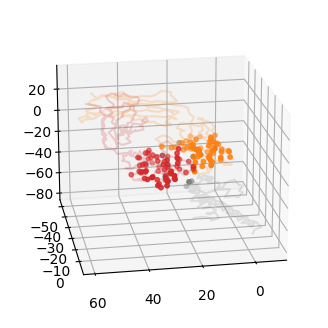

In [9]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

xyz = asb.get_xyz()[0]
chain_idx = asb.get_chain_idx()[0]
chain_ids = asb.get_chain_ids()[0]

for idx in np.unique(chain_idx):
    mask = chain_idx == idx

    chain_id = chain_ids[idx]
    if chain_id == 'A':
        c = 'C3'  # color heavy chain with red
    elif chain_id == 'B':
        c = 'C1'  # color light chain with orange
    else:
        c = 'C7'  # color antigen with grey

    _patch_xyz = xyz[mask & k_nearest_mask, ATOM.CA]
    ax.scatter(_patch_xyz[:, 0], _patch_xyz[:, 1], _patch_xyz[:, 2], c=c, s=10)

    _xyz = xyz[mask, ATOM.CA]
    ax.plot(_xyz[:, 0], _xyz[:, 1], _xyz[:, 2], c=c, alpha=0.2)

    _anchor_xyz = xyz[mask & anchor_mask, ATOM.CA]
    ax.scatter(_anchor_xyz[:, 0], _anchor_xyz[:, 1], _anchor_xyz[:, 2], c='C0', s=10)

ax.view_init(20, 80)

We can see that the nearest 128 residues are mostly from the antibody itself, but not from the antigen.

Can we identify the nearest neighbors only from the antigen? Yes, we can pass `mask` argument to `get_k_nearest_mask` method to confine the computation within the residues specified by the mask.

In [10]:
antigen_mask = asb.get_antigen_mask()[0]
antigen_mask.sum()

k_nearest_mask = asb.get_topk_nearest_residue_mask(query_xyz=anchor_xyz, k=128, mask=antigen_mask)[0]
k_nearest_mask.shape

torch.Size([545])

In [12]:
asb.get_residue_mask()[0].shape

torch.Size([545])

Note that in case when the number of valid residues in the chain is less than `k`, all valid residues in the chain will be returned.

In [20]:
k_nearest_mask.sum(), (antigen_mask & asb.get_residue_mask()[0]).sum()

(tensor(111), tensor(111))

Let's visualize those residues!

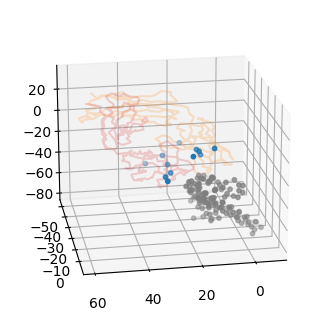

In [14]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

xyz = asb.get_xyz()[0]
chain_idx = asb.get_chain_idx()[0]
chain_ids = asb.get_chain_ids()[0]

for idx in np.unique(chain_idx):
    mask = chain_idx == idx

    chain_id = chain_ids[idx]
    if chain_id == 'A':
        c = 'C3'  # color heavy chain with red
    elif chain_id == 'B':
        c = 'C1'  # color light chain with orange
    else:
        c = 'C7'  # color antigen with grey

    _patch_xyz = xyz[mask & k_nearest_mask, ATOM.CA]
    ax.scatter(_patch_xyz[:, 0], _patch_xyz[:, 1], _patch_xyz[:, 2], c=c, s=10)

    _xyz = xyz[mask, ATOM.CA]
    ax.plot(_xyz[:, 0], _xyz[:, 1], _xyz[:, 2], c=c, alpha=0.2)

    _anchor_xyz = xyz[mask & anchor_mask, ATOM.CA]
    ax.scatter(_anchor_xyz[:, 0], _anchor_xyz[:, 1], _anchor_xyz[:, 2], c='C0', s=10)

ax.view_init(20, 80)

Let's get 32 nearest neighbors instead of 128, to more clearly show that masking really works.

In [27]:
k_nearest_mask = asb.get_topk_nearest_residue_mask(query_xyz=anchor_xyz, k=32, mask=antigen_mask)[0]
k_nearest_mask.shape

torch.Size([545])

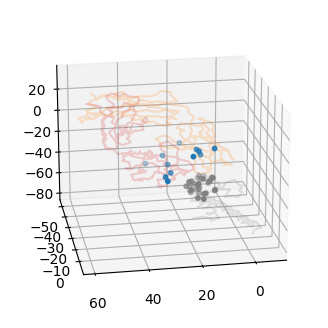

In [28]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

xyz = asb.get_xyz()[0]
chain_idx = asb.get_chain_idx()[0]
chain_ids = asb.get_chain_ids()[0]

for idx in np.unique(chain_idx):
    mask = chain_idx == idx

    chain_id = chain_ids[idx]
    if chain_id == 'A':
        c = 'C3'  # color heavy chain with red
    elif chain_id == 'B':
        c = 'C1'  # color light chain with orange
    else:
        c = 'C7'  # color antigen with grey

    _patch_xyz = xyz[mask & k_nearest_mask, ATOM.CA]
    ax.scatter(_patch_xyz[:, 0], _patch_xyz[:, 1], _patch_xyz[:, 2], c=c, s=10)

    _xyz = xyz[mask, ATOM.CA]
    ax.plot(_xyz[:, 0], _xyz[:, 1], _xyz[:, 2], c=c, alpha=0.2)

    _anchor_xyz = xyz[mask & anchor_mask, ATOM.CA]
    ax.scatter(_anchor_xyz[:, 0], _anchor_xyz[:, 1], _anchor_xyz[:, 2], c='C0', s=10)

ax.view_init(20, 80)